In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from util_data import *
from amorgibbs1 import *
from util_plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

('probtorch:', '0.0+5a2c637', 'torch:', '1.0.0.dev20181029', 'cuda:', True)


In [2]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 40
T_max = 60
K = 4
D = 2
dt = 8
Boundary = 30
noise_ratio = 20.0
## Model Parameters
num_particles_rws = 30
mcmc_steps = 5
num_particles_smc = 30
NUM_HIDDEN = 32
NUM_LATENTS = K*K
NUM_OBS = 2 * K

NUM_EPOCHS = 1000
LEARNING_RATE = 1e-4
CUDA = False
RESTORE = False
PATH_ENC = "SIS/%d-%dtimeseries-%drws-%dsmc%dmcmc-enc-%s" % (T_min, T_max, num_particles_rws, num_particles_smc, mcmc_steps, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

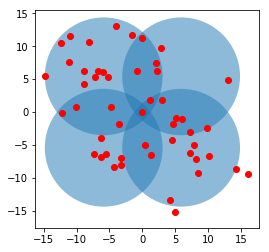

In [3]:
T = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq_T(T, K, dt, Boundary, init_v, noise_cov)
## true global variables
cov_true = np.tile(noise_cov, (K, 1, 1))
dirs = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]])
mu_true = np.tile(np.absolute(init_v), (K, 1)) * dirs
plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs):
        A_samples = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K)
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample()
        return latents_dirs, A_samples

In [5]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [6]:
KLs = []
EUBOs = []
log_qs = []
ESSs = []

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq_T(T, K, dt, Boundary, init_v, noise_cov)
    enc, eubo, kl, ess, latents_dirs, Z_ret = rws_sis(enc, alpha_trans_0, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles_rws, num_particles_smc, mcmc_steps)
    eubo.backward()
    optimizer.step()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ESSs.append(ess)
    optimizer.zero_grad()
    time_end = time.time()
    print('epoch : %d, eubo : %f, KL : %f (%ds)' % (epoch, eubo, kl, time_end - time_start))
    
if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)
    save_params(KLs, EUBOs, ESSs, PATH_ENC)

epoch : 0, eubo : -1811.291138, KL : 12.153669 (13s)
epoch : 1, eubo : -2073.260498, KL : 13.471912 (14s)
epoch : 2, eubo : -1992.863525, KL : 16.472712 (13s)
epoch : 3, eubo : -2281.154785, KL : 15.384992 (15s)
epoch : 4, eubo : -2068.561768, KL : 11.269409 (13s)
epoch : 5, eubo : -2003.326050, KL : 13.851560 (13s)
epoch : 6, eubo : -2240.723877, KL : 17.442104 (15s)
epoch : 7, eubo : -2283.403076, KL : 13.482071 (15s)
epoch : 8, eubo : -2196.670898, KL : 14.046256 (15s)
epoch : 9, eubo : -2049.995850, KL : 12.408105 (13s)
epoch : 10, eubo : -2092.382324, KL : 13.701834 (14s)
epoch : 11, eubo : -1744.676880, KL : 10.265937 (11s)
epoch : 12, eubo : -2043.889526, KL : 13.065166 (13s)
epoch : 13, eubo : -2298.687988, KL : 14.589173 (15s)
epoch : 14, eubo : -2142.738525, KL : 11.845210 (15s)
epoch : 15, eubo : -2248.484375, KL : 12.597082 (15s)
epoch : 16, eubo : -1607.164307, KL : 9.253830 (11s)
epoch : 17, eubo : -1594.705200, KL : 12.043611 (11s)
epoch : 18, eubo : -1959.939941, KL : 1

KeyboardInterrupt: 

In [ ]:
plot_dirs(enc, alpha_trans_0, Z_ret, Zs_true, T, K, num_particles_rws, vmax=15)

In [ ]:
plot_results(EUBOs, log_qs, KLs, ESSs, num_particles_rws)

In [ ]:
if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-(Boundary-radius), Boundary-radius)
ax.set_ylim(-(Boundary-radius), Boundary-radius)
# ax.axis('equal')
plot_cov_ellipse(cov=np.eye(2)*210, pos=np.array([0, 0]), nstd=2, ax=ax, alpha=0.5)

In [ ]:
from torch import logsumexp

In [ ]:
a = torch.Tensor([1,2,3,4])
torch.exp(a - logsumexp(a,dim=0)).sum()